In [1]:
import numpy as np
np.random.seed(11)
import tensorflow as tf
tf.random.set_seed(11)

2023-02-10 07:46:12.688352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hanh/anaconda3/envs/flowers/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import keras.layers as layers
from keras.models import Sequential
from keras.utils import np_utils, load_img, img_to_array

In [3]:
from sklearn.datasets import load_files
from tqdm import tqdm
import pandas as pd

## Load images

In [4]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 102)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('./Data/Datasplit/train')
valid_files, valid_targets = load_dataset('./Data/Datasplit/valid')
test_files, test_targets = load_dataset('./Data/Datasplit/test')

## Convert images to float

In [5]:
def path_to_tensor(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)      
    img = np.expand_dims(img, axis=0)  # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3)
    img = preprocess_input(img)
    return img

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
train_tensors = paths_to_tensor(train_files)
valid_tensors = paths_to_tensor(valid_files)
test_tensors = paths_to_tensor(test_files)

100%|██████████████████████████████████████| 6149/6149 [00:27<00:00, 223.37it/s]


## Use Resnet50 weights

In [7]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
#Loading the ResNet50 model with pre-trained ImageNet weights
resnet = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_tensor=inputs)

2023-02-10 07:47:24.254032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 07:47:24.272579: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
len(resnet.layers)

175

In [9]:
for layer in resnet.layers[:170]: layer.trainable = False

In [10]:
cnn = Sequential([
    resnet,
    layers.GlobalAveragePooling2D(),
    
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(units=102, activation="softmax"),
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,804,902
Trainable params: 1,267,814
Non

In [11]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)

history = cnn.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets), 
                    epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)

In [12]:
cnn.evaluate(train_tensors, train_targets)
cnn.evaluate(valid_tensors, valid_targets)
cnn.evaluate(test_tensors, test_targets);

193/193 [==============================] - 239s 1s/step - loss: 0.7699 - accuracy: 0.8096


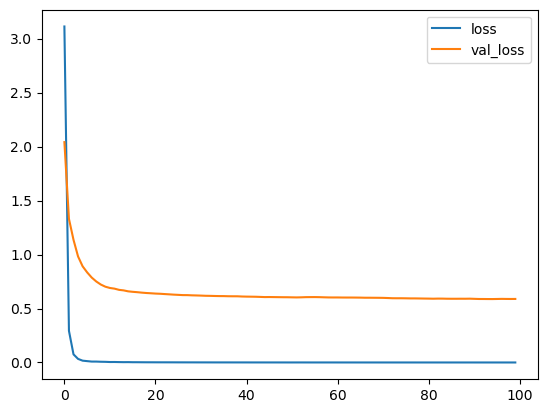

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();